## Ejecución en Google Colab

## Librerias

In [ ]:
import numpy as np
import torch 
import time
import matplotlib.pyplot as plt
import pickle
import os
import gdown
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn

In [ ]:
from google.colab import drive,output

drive.mount('/content/drive')
# !ln -s "/content/drive/MyDrive/Datos ZTF"

Mounted at /content/drive


In [ ]:
!ln -s "/content/drive/MyDrive/Datos ZTF"

## Lectura de datos

In [ ]:
# path = "D:/codigos/Autoencoder/ZTF/Dataset/td_ztf_stamp_17_06_20-002.pkl"
if not os.path.isfile(path):
    url = 'https://drive.google.com/drive/folders/1vqfoxF-KyMNnLxABZZ_kb76DrUrixEud'
    output="D:/codigos/Autoencoder/ZTF/Dataset"
    gdown.download_folder(url,output, quiet=False)

In [ ]:
# path = "D:/codigos/Autoencoder/ZTF/Dataset/datosAutoencoder.npy"
if not os.path.isfile(path):
    with open('D:/codigos/Autoencoder/ZTF/Dataset/td_ztf_stamp_17_06_20-002.pkl', 'rb') as f:
        data = pickle.load(f)
    print(data.keys())

dict_keys(['Train', 'Validation', 'Test'])


In [ ]:

# if not os.path.isfile(path):
with open('/content/Datos ZTF/td_ztf_stamp_17_06_20.pkl', 'rb') as f:
    data = pickle.load(f)
print(data.keys())

dict_keys(['Train', 'Validation', 'Test'])


## Exploracion

In [ ]:
print("Dimension, tipo, llaves")
print(np.shape(data["Train"]),type(data["Train"]),data["Train"].keys())

Dimension, tipo, llaves
() <class 'dict'> dict_keys(['images', 'labels', 'features'])


In [ ]:
print("Cantidad de muestras")
print(np.shape(data["Train"]["labels"]))
print(np.shape(data["Validation"]["labels"]))
print(np.shape(data["Test"]["labels"]))
print("Dimensiones")
print(np.shape(data["Train"]["images"]))
print(np.shape(data["Validation"]["images"]))
print(np.shape(data["Test"]["images"]))

Cantidad de muestras
(72710,)
(500,)
(500,)
Dimensiones
(72710, 63, 63, 3)
(500, 63, 63, 3)
(500, 63, 63, 3)


## Procesamiento
Recorte a 21 x 21

In [ ]:
datatrain=np.zeros([len(data["Train"]["images"]),21,21,3])
dataval=np.zeros([len(data["Validation"]["images"]),21,21,3])
datatest=np.zeros([len(data["Test"]["images"]),21,21,3])

for id,muestra in enumerate(data["Train"]["images"]):
    datatrain[id]=muestra[ 21:42 , 21:42 ]
for id,muestra in enumerate(data["Validation"]["images"]):
    dataval[id]=muestra[ 21:42 , 21:42 ]
for id,muestra in enumerate(data["Test"]["images"]):
    datatest[id]=muestra[ 21:42 , 21:42 ]

In [ ]:
datatrain_tensor = torch.Tensor(datatrain)
datatrain_tensor = datatrain_tensor.permute(0, 3, 1, 2)
my_datatrain = TensorDataset(datatrain_tensor,torch.Tensor(data["Train"]["labels"]))


In [ ]:
dataval_tensor = torch.Tensor(dataval)
dataval_tensor = dataval_tensor.permute(0, 3, 1, 2)
my_dataval = TensorDataset(dataval_tensor,torch.Tensor(data["Validation"]["labels"]))

## Funciones de entrenamiento

In [ ]:
def show_curves(curves):
    fig, ax = plt.subplots(1, 2, figsize=(13, 5))
    fig.set_facecolor('white')

    epochs = np.arange(len(curves["val_loss"])) + 1

    ax[0].plot(epochs, curves['val_loss'], label='validation')
    ax[0].plot(epochs, curves['train_loss'], label='training')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].set_title('Loss evolution during training')
    ax[0].legend()

    ax[1].plot(epochs, curves['val_acc'], label='validation')
    ax[1].plot(epochs, curves['train_acc'], label='training')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_title('Accuracy evolution during training')
    ax[1].legend()

    plt.show()

def train_model(
    model,
    criterioy,
    criteriox,
    train_dataset,
    val_dataset,
    num_epoch,
    batch_size,
    lr,
    use_gpu=False
):
    if use_gpu:
        model.cuda()


    # Definición de dataloader
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=use_gpu)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False, pin_memory=use_gpu)
    num_total_steps=len(train_loader)
    # Optimizador
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Listas para guardar curvas de entrenamiento
    curves = {
        "train_acc": [],
        "val_acc": [],
        "train_loss": [],
        "val_loss": []
    }


    t0 = time.perf_counter()

    for epoch in range(num_epoch):
        cumulative_train_loss = 0
        cumulative_train_corrects = 0
        train_acc_count=0
        # Entrenamiento del modelo
        model.train()
        for i, (x_batch, y_batch) in enumerate(train_loader):
            print(f"\rEpoch {epoch + 1}/{num_epoch} - Batch {i}/{len(train_loader)}", end="")
            if use_gpu:
                x_batch = x_batch.cuda()
                y_batch = y_batch.cuda()

            # Predicción
            x_reconstructed, y_predicted = model(x_batch)
            if use_gpu:
                y_batch = y_batch.type(torch.LongTensor).cuda()
            else:
                y_batch = y_batch.type(torch.LongTensor)
            # y_batch = y_batch.reshape(-1, 1)

            # Cálculo de loss
           
            loss_y = criterioy(y_predicted,y_batch)
            loss_x = criteriox(x_reconstructed, x_batch)
           

            loss=loss_y*0.05+loss_x*0.95

            # Actualización de parámetros
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            cumulative_train_loss += loss.item()

            # Calculamos número de aciertos
            class_prediction = torch.argmax(y_predicted, axis=1).long()
            train_acc_count += y_batch.shape[0]

            cumulative_train_corrects += (y_batch == class_prediction).sum().item()
        train_acc=cumulative_train_corrects / train_acc_count
        train_loss=cumulative_train_loss/num_total_steps
        print(f"Epoch [{epoch+1}/{num_epoch}],  Loss:{train_loss:.4f}, acc train: {train_acc:.4f}")

        # Evaluación del modelo
        model.eval()
        with torch.no_grad():
            val_acc_count=0
            cumulative_val_corrects=0
            for x_val, y_val in val_loader:
                if use_gpu:
                    x_val = x_val.cuda()
                    y_val = y_val.cuda()

                x_reconstructed, y_predicted = model(x_val)
                if use_gpu:

                    y_val = y_val.type(torch.LongTensor).cuda()
                else:
                    y_val = y_val.type(torch.LongTensor).cuda()
                class_prediction = torch.argmax(y_predicted, axis=1).long()
                val_acc_count += y_val.shape[0]
                cumulative_val_corrects += (y_val == class_prediction).sum().item()
                # Cálculo de loss
                loss_y_val = criterioy(y_predicted, y_val)
                loss_x_val = criteriox(x_reconstructed, x_val)

                loss_val=loss_y_val*0.05+loss_x_val*0.95

        val_acc=cumulative_val_corrects / val_acc_count
        val_loss=loss_val.item()

        print(f"\t, Loss:{val_loss:.4f}, acc val: {val_acc:.4f}")

        curves["train_acc"].append(train_acc)
        curves["val_acc"].append(val_acc)
        curves["train_loss"].append(train_loss)
        curves["val_loss"].append(val_loss)
    model.cpu()
    print(f"Tiempo total de entrenamiento: {time.perf_counter() - t0:.4f} [s]")

    return curves

## Autoencoder

In [ ]:
class AutoEncoderV5(nn.Module):
    def __init__(self,):
        super().__init__()
        self.encoder = nn.Sequential(

            # Bloque 1
            # [3x21x21]
            nn.ZeroPad2d(3),
            # [3x27x27]
            nn.Conv2d(3, 16, kernel_size=4, padding="same"),
            nn.ReLU(),
            # [16, 24, 24]
            nn.Conv2d(16, 32, kernel_size=3, padding="same"),
            nn.ReLU(),
            # [32, 24, 24]
            nn.AvgPool2d(kernel_size=2),
            # [32, 12, 12]

            # Bloque 2
            nn.Conv2d(32, 32, kernel_size=3, padding="same"),
            nn.ReLU(),
            # [32, 12, 12]
            nn.Conv2d(32, 64, kernel_size=3, padding="same"),
            nn.ReLU(),
            # [64, 12, 12]
            nn.AvgPool2d(kernel_size=2),
            # [64, 6, 6]

            # Bloque 3
            nn.Conv2d(64, 64, kernel_size=3, padding="same"),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, padding="same"),
            nn.ReLU(),
            # [128, 6, 6]
            nn.AvgPool2d(kernel_size=2),
            # [128, 3, 3]

            # Bloque 4
            nn.Conv2d(128, 128, kernel_size=3, padding="same"),
            nn.ReLU(),
            # [128, 3, 3]
            nn.AvgPool2d(kernel_size=2),
            # [128, 1, 1]   
        )
        self.decoder = nn.Sequential(
            # BLoque 1
            # [128, 1, 1]
            nn.ConvTranspose2d(128, 64, 2,stride=1),
            nn.ReLU(),
            # [64, 2, 2]

            # BLoque 2
            nn.ConvTranspose2d(64, 64, 3,stride=2),
            nn.ReLU(),
            # [64, 5, 5]
            nn.ConvTranspose2d(64, 32, 1,stride=1),
            nn.ReLU(),
            # [32, 5, 5]

            # Bloque 3
            nn.ConvTranspose2d(32, 32, 2,stride=2),
            nn.ReLU(),
            # [32, 10, 10]
            nn.ConvTranspose2d(32, 32, 1,stride=1),
            nn.ReLU(),
            # [32, 10, 10]

            # BLoque 4
            nn.ConvTranspose2d(32, 16, 3,stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 16, 1,stride=1),
            nn.ReLU(),
            # Bloque 5
            nn.ConvTranspose2d(16, 3, 1,stride=1),
            nn.ReLU(),
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(p=0.8),
            nn.Linear(128,64),
            nn.ReLU(),
            # Rotation concat
            # cyclic pooling
            nn.Linear(64,64),
            nn.ReLU(),
            nn.Linear(64,64),
            nn.ReLU(),
            nn.Linear(64,5),
            nn.Softmax(dim=1),

        )

    def forward(self, x):
            encoder = self.encoder(x)
            decoder = self.decoder(encoder)
            classification = self.classifier(encoder)
            return decoder,classification

## Entrenamiento

In [ ]:
model=AutoEncoderV5()
num_epoch=50
lr=1e-4
batch=32
criterio1=nn.CrossEntropyLoss()
criterio2=nn.MSELoss()
# def train_model(
#     model,
#     criterioy,
#     criteriox,
#     train_dataset,
#     val_dataset,
#     num_epoch,
#     batch_size,
#     lr,
#     use_gpu=False

history=train_model(model,criterio1,criterio2,my_datatrain,my_dataval,num_epoch,batch,lr,True)

Epoch 1/50 - Batch 2272/2273Epoch [1/50],  Loss:0.1370, acc train: 0.3571
	, Loss:0.1337, acc val: 0.4180
Epoch 2/50 - Batch 2272/2273Epoch [2/50],  Loss:0.1301, acc train: 0.5411
	, Loss:0.1260, acc val: 0.6060
Epoch 3/50 - Batch 2272/2273Epoch [3/50],  Loss:0.1270, acc train: 0.5924
	, Loss:0.1238, acc val: 0.6400
Epoch 4/50 - Batch 2272/2273Epoch [4/50],  Loss:0.1252, acc train: 0.6250
	, Loss:0.1232, acc val: 0.6420
Epoch 5/50 - Batch 2272/2273Epoch [5/50],  Loss:0.1036, acc train: 0.6438
	, Loss:0.0723, acc val: 0.6420
Epoch 6/50 - Batch 2272/2273Epoch [6/50],  Loss:0.0690, acc train: 0.6572
	, Loss:0.0668, acc val: 0.6720
Epoch 7/50 - Batch 2272/2273Epoch [7/50],  Loss:0.0670, acc train: 0.6648
	, Loss:0.0663, acc val: 0.6740
Epoch 8/50 - Batch 2272/2273Epoch [8/50],  Loss:0.0660, acc train: 0.6759
	, Loss:0.0654, acc val: 0.6840
Epoch 9/50 - Batch 2272/2273Epoch [9/50],  Loss:0.0653, acc train: 0.6829
	, Loss:0.0648, acc val: 0.6960
Epoch 10/50 - Batch 2272/2273Epoch [10/50],  L

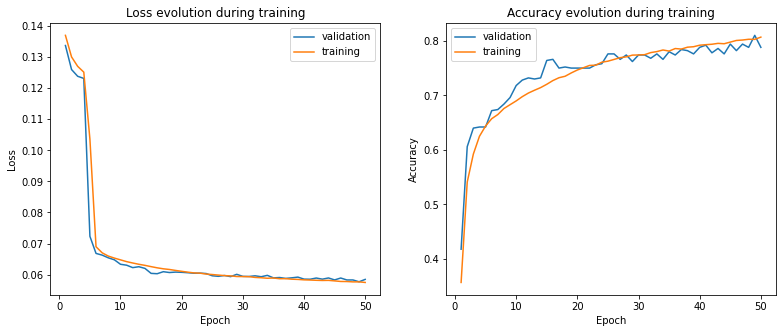

In [ ]:
show_curves(history)

In [ ]:
num_epoch=10
lr=1e-4
batch=64
criterio1=nn.CrossEntropyLoss()
criterio2=nn.MSELoss()
# def train_model(
#     model,
#     criterioy,
#     criteriox,
#     train_dataset,
#     val_dataset,
#     num_epoch,
#     batch_size,
#     lr,
#     use_gpu=False

history=train_model(model,criterio1,criterio2,my_datatrain,my_dataval,num_epoch,batch,lr,True)

Epoch 1/10 - Batch 1136/1137Epoch [1/10],  Loss:0.0579, acc train: 0.7967
	, Loss:0.0587, acc val: 0.7820
Epoch 2/10 - Batch 1136/1137Epoch [2/10],  Loss:0.0578, acc train: 0.7992
	, Loss:0.0575, acc val: 0.8100
Epoch 3/10 - Batch 1136/1137Epoch [3/10],  Loss:0.0577, acc train: 0.7996
	, Loss:0.0578, acc val: 0.7960
Epoch 4/10 - Batch 1136/1137Epoch [4/10],  Loss:0.0578, acc train: 0.7978
	, Loss:0.0583, acc val: 0.7900
Epoch 5/10 - Batch 1136/1137Epoch [5/10],  Loss:0.0578, acc train: 0.7987
	, Loss:0.0580, acc val: 0.8000
Epoch 6/10 - Batch 1136/1137Epoch [6/10],  Loss:0.0577, acc train: 0.8006
	, Loss:0.0583, acc val: 0.7880
Epoch 7/10 - Batch 1136/1137Epoch [7/10],  Loss:0.0577, acc train: 0.8008
	, Loss:0.0584, acc val: 0.7860
Epoch 8/10 - Batch 1136/1137Epoch [8/10],  Loss:0.0576, acc train: 0.8021
	, Loss:0.0579, acc val: 0.7980
Epoch 9/10 - Batch 1136/1137Epoch [9/10],  Loss:0.0575, acc train: 0.8031
	, Loss:0.0585, acc val: 0.7860
Epoch 10/10 - Batch 1136/1137Epoch [10/10],  L

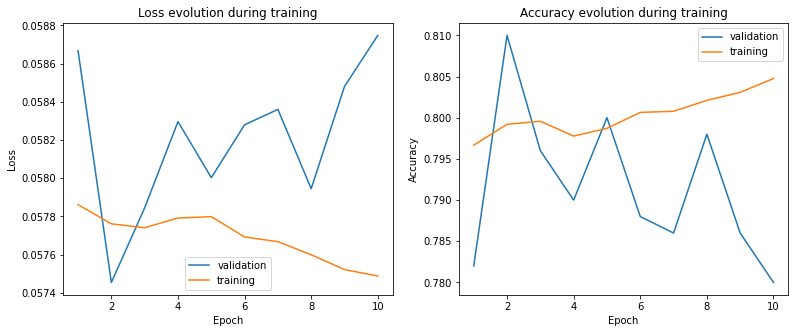

In [ ]:
show_curves(history)

In [ ]:
torch.save(model.state_dict(),"./AutoencoderClasificador10.pth")